In [ ]:
!pip install transformers

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
import csv
import gc
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1. Import data

In [2]:
# Set the absolute path to your data directory
data_directory = Path("/kaggle/input/data-science-challenge")

# Train data
y_train_file = "y_train.txt"
# Test data
test_file = "test.txt"
# Year data
year_file = "year.txt"
# Edges Features
edge_file = 'features_edgelist.csv'
# Authors Features
author_file = 'features_authors.csv'
# Clean Abstract
cl_abstract_file = 'cleaned_abstracts_scibert.csv'

y_train_path     = data_directory / y_train_file
test_path        = data_directory / test_file
year_path        = data_directory / year_file
edge_path        = data_directory / edge_file
author_path      = data_directory / author_file
cl_abstract_path = data_directory / cl_abstract_file

### 1.1 All data

In [3]:
###  Import Numeric features ###

df_edgelist = pd.read_csv(edge_path)
df_authors = pd.read_csv(author_path)
df_year = pd.read_csv(year_path, header=None)
df_year.columns = ['paper_id','year']

## Fill N/A values ##
# Define the list of columns to fill (weight_class)
columns_to_fill = ['class0_weight', 'class1_weight', 'class2_weight', 'class3_weight', 'class4_weight']

# Loop over each column and fillna
for column in columns_to_fill:
    df_edgelist[column] = df_edgelist[column].fillna(0)
    df_authors[column] = df_authors[column].fillna(0)

df_edgelist['total_references'] = df_edgelist['total_references'].fillna(0)  
df_authors['total_references']  = df_authors['total_references'].fillna(0)  
    
# Numeric Features (Edgelist/Year/Author)
df_numeric = pd.merge(df_edgelist,df_year, on='paper_id')
df_numeric = pd.merge(df_numeric,df_authors,on='paper_id')


###  Import Text features ###
df_text = pd.read_csv(cl_abstract_path)
df_text['abstract'].fillna('', inplace=True)

### 1.2 Train data

In [5]:
#####  Train data #####
y_train = pd.read_csv(y_train_path, header=None)
y_train.columns = ['paper_id','class']

# Merge 1 (Class - text)
merged_df = pd.merge(y_train, df_text, on="paper_id", how="inner")
# Merge 2 (Class - text - numeric)
df_train = pd.merge(merged_df, df_numeric, on="paper_id", how="inner")

### 1.3 Test data

In [6]:
#####  Test data #####
test_papers = list()
with open(test_path, "r") as f:
    for line in f:
        t = line.split(',')
        test_papers.append(int(t[0]))

# Merge text / numeric data
df_all = pd.merge(df_text, df_numeric, on="paper_id", how="inner")

# Find test data
df_test = df_all[df_all['paper_id'].isin(test_papers)]

## 2. Model Architectures

In [7]:
import tensorflow as tf
import keras
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.layers import Input, Dropout, Dense, Concatenate
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.utils.vis_utils import plot_model  

### Define Functions (Plots, tokenization etc)

In [8]:
def print_results(hs, metric = 'val_loss'):
    min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(hs.history[metric]))
    print('Best Epoch: ', idx+1)
    print("---")
    print("Train Loss     : {0:.5f}".format(hs.history['loss'][idx]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][idx]))

def plot_history(hs, epochs, metric):
    print()
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [16, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(range(1, epochs + 1), hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(range(1, epochs + 1), hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(1, epochs + 1,  1)
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

def tokenize_abstracts(abstracts, tokenizer, max_length=512):
    input_ids, attention_masks = [], []

    for abstract in abstracts:
        tokens = tokenizer.encode_plus(abstract, max_length=max_length, padding='max_length', truncation=True)
        input_ids.append(tokens['input_ids'])
        attention_masks.append(tokens['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

### 2.1 SciBERT

#### Preprocess the input data

In [9]:
# Get numeric features
numeric_features_train = df_train[['class0_weight_x', 'class1_weight_x', 'class2_weight_x', 'class3_weight_x', 'class4_weight_x', 
                                   'total_references_x','year']].values
numeric_features_test = df_test[['class0_weight_x', 'class1_weight_x', 'class2_weight_x', 'class3_weight_x', 'class4_weight_x',                               
                                 'total_references_x','year']].values

# Normalize the 'total_reference' and 'year' column and flatten the features
scaler = MinMaxScaler()
# Normalize 'total_references_x'
numeric_features_train[:, -2] = scaler.fit_transform(numeric_features_train[:, -2].reshape(-1, 1)).flatten()
numeric_features_test[:, -2] = scaler.transform(numeric_features_test[:, -2].reshape(-1, 1)).flatten()
# Normalize 'year'
numeric_features_train[:, -1] = scaler.fit_transform(numeric_features_train[:, -1].reshape(-1, 1)).flatten()
numeric_features_test[:, -1] = scaler.transform(numeric_features_test[:, -1].reshape(-1, 1)).flatten()

# One hot encode the classes output
y_train = keras.utils.to_categorical(df_train['class'].values, num_classes=5)

In [10]:
# Tokenize the abstract 
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

train_input_ids, train_attention_masks = tokenize_abstracts(df_train.abstract, tokenizer)
test_input_ids, test_attention_masks = tokenize_abstracts(df_test.abstract, tokenizer)

# Get final input dataset 
train_dataset = (train_input_ids, train_attention_masks, numeric_features_train, y_train)
test_dataset = (test_input_ids, test_attention_masks, numeric_features_test)

In [11]:
# Compute class weights / Use for Imbalance dataset
weights = class_weight.compute_sample_weight(class_weight='balanced', y=df_train['class'].values)

# Create a dictionary mapping class indices to weights
class_weights = {i: weight for i, weight in enumerate(weights)}

#### Create Model

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109918464   ['input_4[0][0]',                
                                thPoolingAndCrossAt               'input_5[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

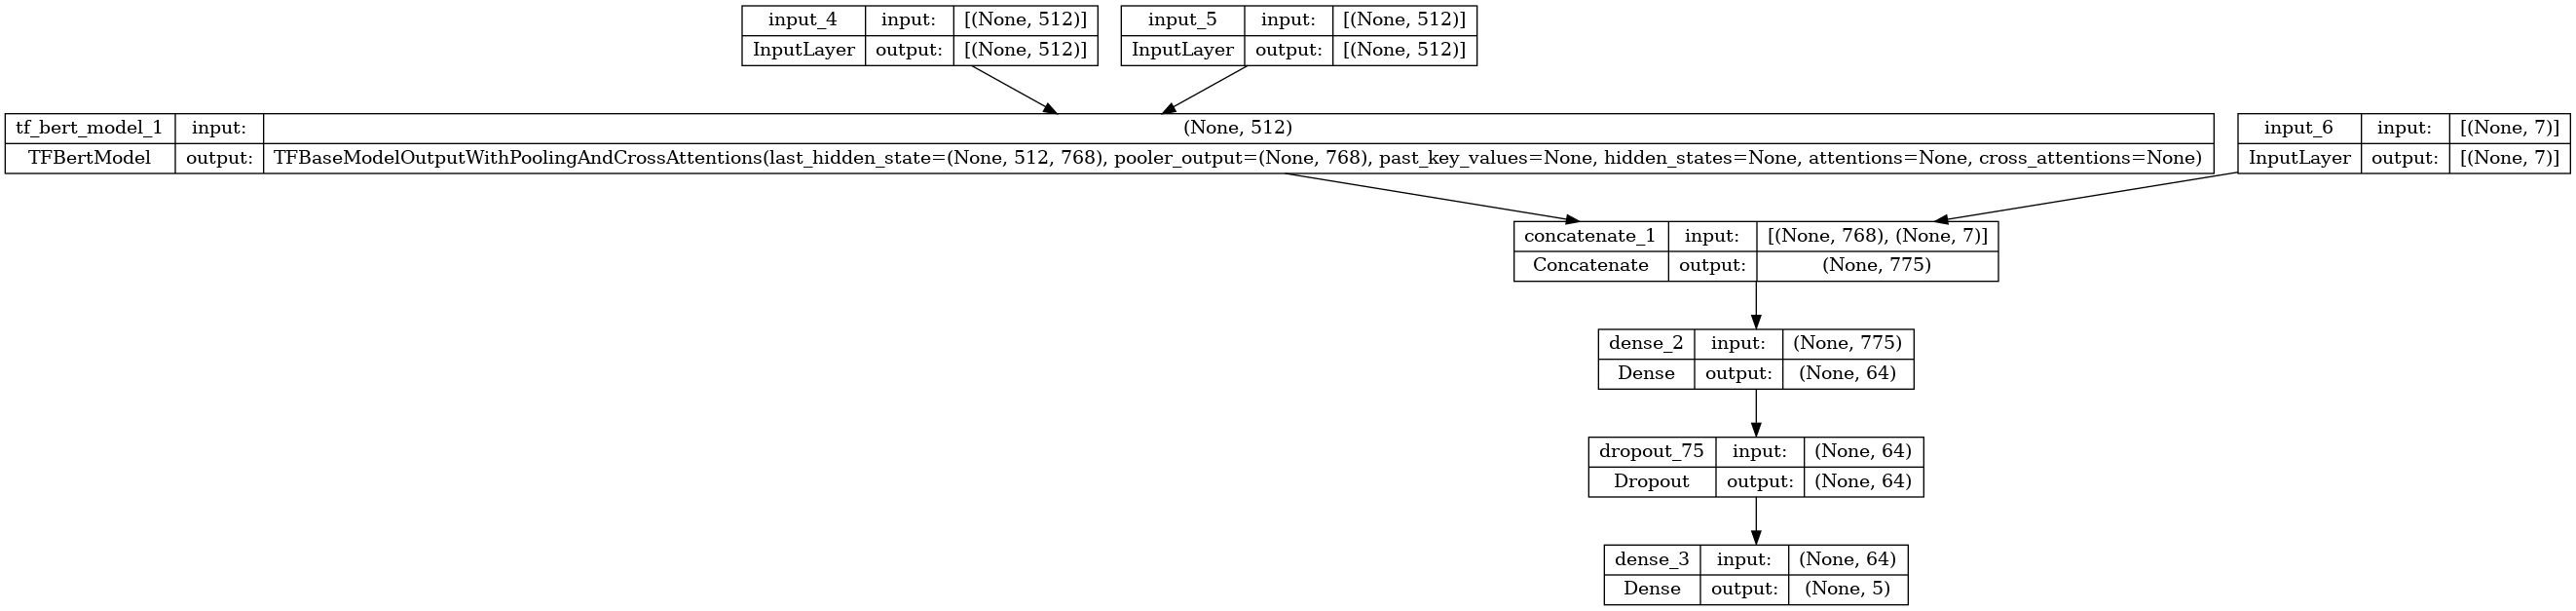

In [14]:
# SciBERT inputs
input_ids = Input(shape=(512,), dtype='int32')
attention_masks = Input(shape=(512,), dtype='int32')

# Numeric features input (7 numeric features, Weight_classes, Total References, Year)
numeric_inputs = Input(shape=(7,), dtype='float32')

# Load the SciBERT model
scibert = TFAutoModel.from_pretrained('allenai/scibert_scivocab_uncased', from_pt=True)

# Freeze the layer weights of the SciBERT model
scibert.trainable = False

# SciBERT layer
scibert_output = scibert(input_ids, attention_mask=attention_masks)[1]

# Concatenate SciBERT output with numeric features
merged = Concatenate()([scibert_output, numeric_inputs])

# Dense layer
dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(merged)
dropout = Dropout(0.2)(dense)
output_classes = Dense(5, activation='softmax')(dropout)

# Model
model = Model(inputs=[input_ids, attention_masks, numeric_inputs], outputs=output_classes)


# Optimizer
learning_rate = ExponentialDecay(initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, 
              loss=CategoricalCrossentropy(), 
              metrics=[CategoricalAccuracy()])

# Model Summary
model.summary()

# Plot the model diagram
plot_model(model, to_file='model_diagram.png', show_shapes=True)

#### Training / Top Layer

In [ ]:
checkpoint = [ModelCheckpoint(filepath='/kaggle/working/best_weights_sciBERT_model_top_layers.h5', 
                             monitor='val_loss',
                             verbose = 1,
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True)]

history = model.fit(
    x=(train_dataset[0], train_dataset[1], train_dataset[2]),
    y=train_dataset[3],
    batch_size=16,
    epochs=20,
    verbose=1,
    validation_split=0.1,
    callbacks=[checkpoint],
    class_weight=class_weights
)

Epoch 1/20
1978/1978 [==============================] - ETA: 0s - loss: 0.6674 - categorical_accuracy: 0.7933
Epoch 1: val_loss improved from inf to 0.51674, saving model to /kaggle/working/best_weights_sciBERT_model_top_layers.h5
1978/1978 [==============================] - 1696s 831ms/step - loss: 0.6674 - categorical_accuracy: 0.7933 - val_loss: 0.5167 - val_categorical_accuracy: 0.8465
Epoch 2/20
1978/1978 [==============================] - ETA: 0s - loss: 0.5269 - categorical_accuracy: 0.8456
Epoch 2: val_loss improved from 0.51674 to 0.49534, saving model to /kaggle/working/best_weights_sciBERT_model_top_layers.h5
1978/1978 [==============================] - 1582s 800ms/step - loss: 0.5269 - categorical_accuracy: 0.8456 - val_loss: 0.4953 - val_categorical_accuracy: 0.8553
Epoch 3/20
1978/1978 [==============================] - ETA: 0s - loss: 0.5152 - categorical_accuracy: 0.8499
Epoch 3: val_loss improved from 0.49534 to 0.46346, saving model to /kaggle/working/best_weights_sci

Best Epoch:  20
---
Train Loss     : 0.56955
Validation Loss: 0.40684



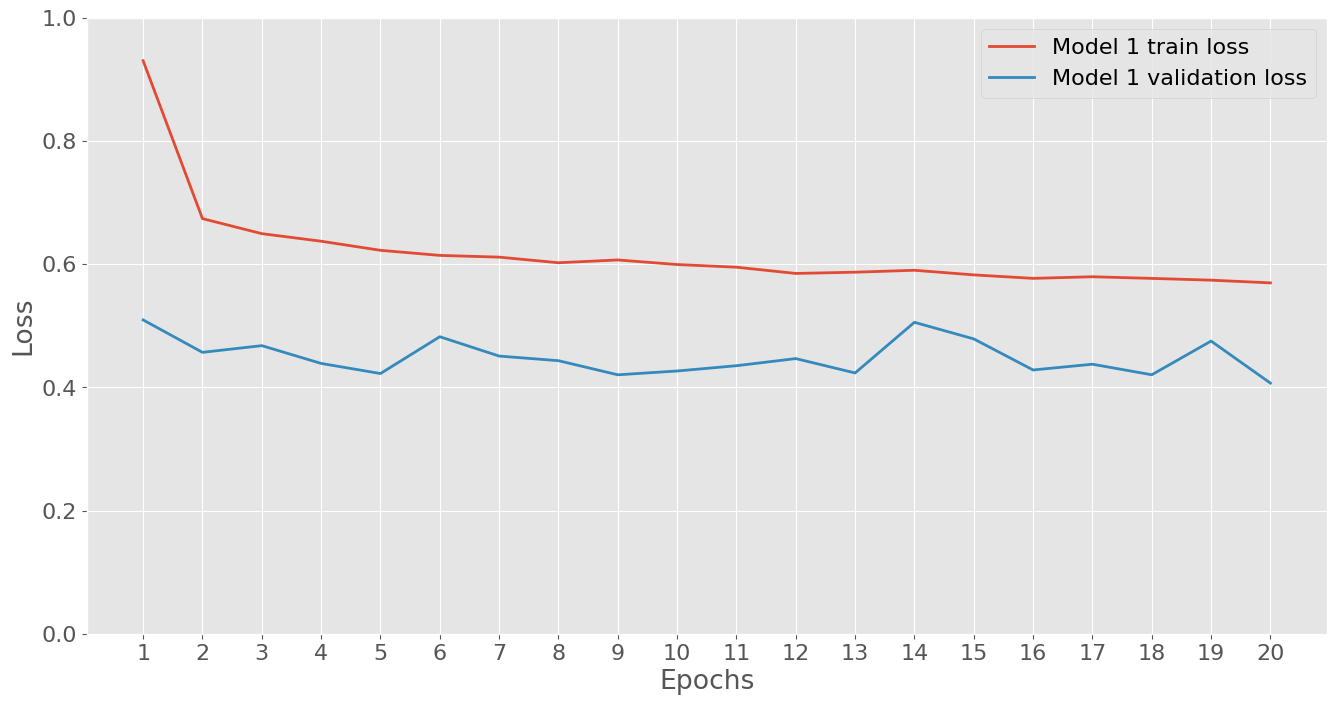

In [31]:
# Print results
print_results(history)

# Plot train and validation error per epoch.
plot_history(hs={'Model 1': history}, epochs=20, metric='loss')

#### Fine-tuning the model

In [18]:
# Load the best weights 
model.load_weights('/kaggle/input/data-science-challenge/best_weights_sciBERT_model_top_layers (2).h5')

# Unfreeze the SciBERT layers
scibert.trainable = True

# Optimizer
optimizer = Adam(learning_rate=1e-5)

# Compile the model
model.compile(optimizer=optimizer, 
              loss=CategoricalCrossentropy(), 
              metrics=[CategoricalAccuracy()])

# Model Summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109918464   ['input_4[0][0]',                
                                thPoolingAndCrossAt               'input_5[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

In [ ]:
checkpoint = [ModelCheckpoint(filepath='/kaggle/working/best_weights_sciBERT_model_fine_tune.h5', 
                             monitor='val_loss',
                             verbose = 1,
                             mode='min',
                             save_best_only=False,
                             save_weights_only=True)]
history_tune = model.fit(
    x=(train_dataset[0], train_dataset[1], train_dataset[2]),
    y=train_dataset[3],
    batch_size=8,
    epochs=5,
    verbose=1,
    validation_split=0.1,
    callbacks=[checkpoint],
    class_weight=class_weights
)

Epoch 1/5
3956/3956 [==============================] - ETA: 0s - loss: 0.3979 - categorical_accuracy: 0.8852
Epoch 1: saving model to /kaggle/working/best_weights_sciBERT_model_fine_tune.h5
3956/3956 [==============================] - 3963s 991ms/step - loss: 0.3979 - categorical_accuracy: 0.8852 - val_loss: 0.3392 - val_categorical_accuracy: 0.9056
Epoch 2/5
3956/3956 [==============================] - ETA: 0s - loss: 0.3160 - categorical_accuracy: 0.9118
Epoch 2: saving model to /kaggle/working/best_weights_sciBERT_model_fine_tune.h5
3956/3956 [==============================] - 3920s 991ms/step - loss: 0.3160 - categorical_accuracy: 0.9118 - val_loss: 0.3343 - val_categorical_accuracy: 0.9062
Epoch 3/5
1751/3956 [============>.................] - ETA: 34:32 - loss: 0.2410 - categorical_accuracy: 0.9368

Best Epoch:  3
---
Train Loss     : 0.23773
Validation Loss: 0.27496



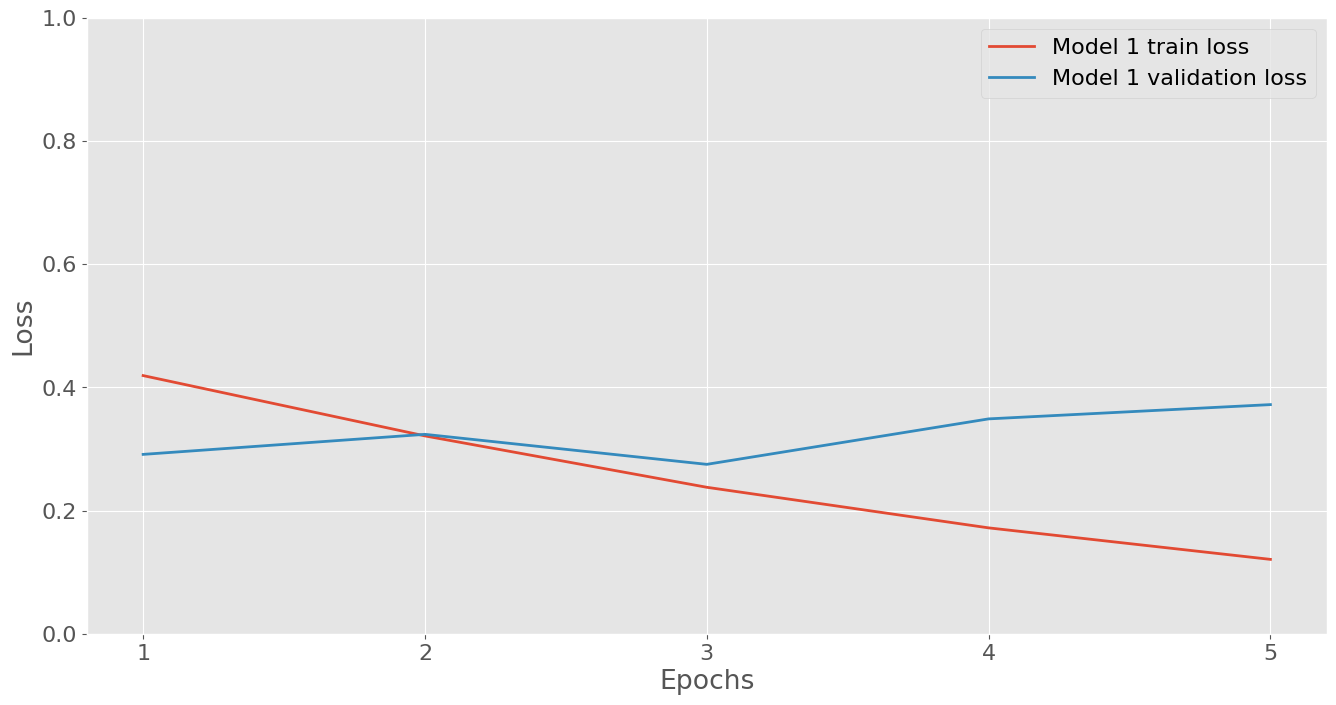

In [23]:
# Print results
print_results(history_tune)

# Plot train and validation error per epoch.
plot_history(hs={'Model 1': history_tune}, epochs=5, metric='loss')

#### Predictions

In [20]:
# Load the best weights (fine tuned model) 
model.load_weights('/kaggle/working/best_weights_sciBERT_model_fine_tune.h5')

predictions = model.predict((test_dataset[0], test_dataset[1], test_dataset[2]))

126/126 [==============================] - 219s 1s/step


In [21]:
# Write predictions to a file
with open('/kaggle/working/sample_submissions_model_SciBERT_top_layers_v3.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(5):
        lst.append('class_'+str(i))
    lst.insert(0, "paperID")
    writer.writerow(lst)
    for i,test_paper in enumerate(test_papers):
        lst = predictions[i,:].tolist()
        lst.insert(0, test_paper)
        writer.writerow(lst)